<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_MP3_BitPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Milestone Project: BitPredict

**Forecasting: Principles and Practice** (3rd ed): https://otexts.com/fpp3/

by Rob J Hyndman and George Athanasopoulos

Monash University, Australia

# Importações

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import absl.logging, os

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Add, Conv1D, Dense, Input, Lambda, Layer, LSTM, Subtract
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import minmax_scale

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

absl.logging.set_verbosity(absl.logging.ERROR)  # Apresentar apenas erros.

## Constantes

In [4]:
SEMENTE = 2008193

COR_TREINO   = '#663399'
COR_PREVISAO = '#f22424'
COR_TESTE    = '#345cd3'

LINHA_ESPESSURA = 1

TAMANHO_CNN = 128

ATIVACAO_CNN = 'relu'
ATIVACAO_HORIZONTE = 'linear'
ATIVACAO_RNN = 'tanh'

PERDA = 'mae'
METRICAS = ['mae', 'mse']

ITERACOES = 100
TAMANHO_LOTE = 128
CAMINHO_MARCOS = 'marcos'

FILTROS = 128
PREENCHIMENTO = 'causal'

UNIDADES = 128

TAMANHO_LOTE_DATASET = 1024  # Seção 5.2

## Funções

In [5]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes_temporais.py

--2023-02-11 19:39:03--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes_temporais.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3787 (3.7K) [text/plain]
Saving to: ‘funcoes_temporais.py’

funcoes_temporais.p 100%[===================>]   3.70K  --.-KB/s    in 0s      

2023-02-11 19:39:04 (45.1 MB/s) - ‘funcoes_temporais.py’ saved [3787/3787]



In [6]:
from funcoes_temporais import grafico_series, grafico_metrica, mean_absolute_scaled_error, metricas_modelo, criar_janelas, separar_janelas_treino_teste, criar_marco_modelo

# Dados

In [7]:
colunas = ['Data', 'Abertura', 'Máximo', 'Mínimo', 'Fechamento']

df = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/dados/BTC_USD_20140917_20230131.csv',
                 header=0,
                 names=colunas,
                 usecols=colunas,
                 parse_dates=['Data'],
                 index_col=['Data'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3059 entries, 2014-09-17 to 2023-01-31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Abertura    3059 non-null   float64
 1   Máximo      3059 non-null   float64
 2   Mínimo      3059 non-null   float64
 3   Fechamento  3059 non-null   float64
dtypes: float64(4)
memory usage: 119.5 KB


In [9]:
df

,Abertura,Máximo,Mínimo,Fechamento
Data,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...
2023-01-27,23030.716797,23417.720703,22654.593750,23078.728516
2023-01-28,23079.964844,23165.896484,22908.845703,23031.089844
2023-01-29,23031.449219,23919.890625,22985.070313,23774.566406


In [10]:
df.describe()

,Abertura,Máximo,Mínimo,Fechamento
count,3059.000000,3059.000000,3059.000000,3059.000000
mean,12931.188036,13256.306288,12570.103885,12937.054107
std,16126.299406,16538.601114,15650.315751,16122.253398
min,176.897003,211.731003,171.509995,178.102997
25%,688.562011,704.736023,674.479981,689.175506
50%,7194.892090,7356.223633,7029.289063,7202.844238
75%,17092.044922,17464.872071,16789.533203,17097.668945
max,67549.734375,68789.625000,66382.062500,67566.828125


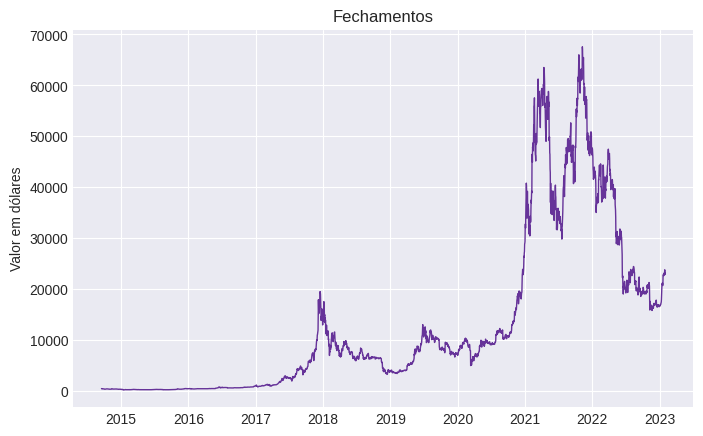

In [11]:
sns.lineplot(data=df, x='Data', y='Fechamento', color=COR_TREINO, linewidth=LINHA_ESPESSURA)

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares');

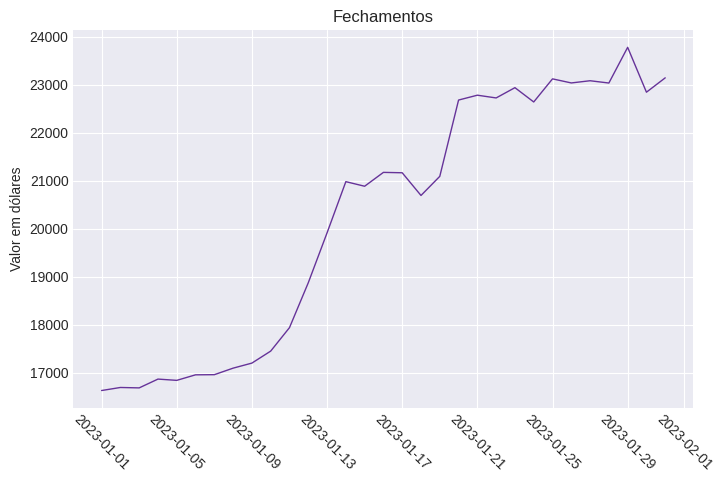

In [12]:
df_recente = df[df.index >= '2023-01-01']

sns.lineplot(data=df_recente, x='Data', y='Fechamento', color=COR_TREINO, linewidth=LINHA_ESPESSURA)

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares')

plt.xticks(rotation=-45);

In [13]:
treino_tamanho = int(len(df) * 0.8)  # 80% da base
treino_tamanho

2447

In [14]:
X_train = df[:treino_tamanho].index
y_train = df[:treino_tamanho]['Fechamento'].to_numpy()

X_test = df[treino_tamanho:].index
y_test = df[treino_tamanho:]['Fechamento'].to_numpy()

len(X_train), len(y_train), len(X_test), len(y_test)

(2447, 2447, 612, 612)

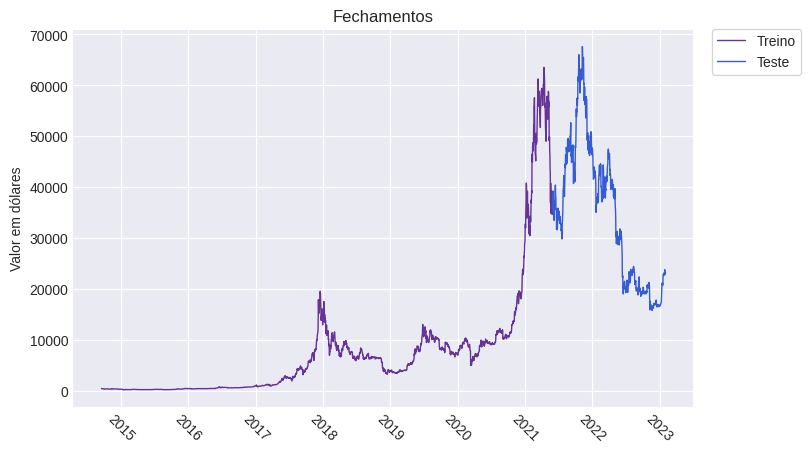

In [15]:
grafico_series(X_treino=X_train, y_treino=y_train,
               X_teste=X_test, y_teste=y_test)

## Dados multivariados (Modelo 6)

What Is Bitcoin Halving? https://www.forbes.com/uk/advisor/investing/cryptocurrency/bitcoin-halving/

In [16]:
df['Premio'] = np.select([df.index < '2016-07-09',
                          df.index < '2020-05-18',
                          True],
                         [25, 12.5, 6.25])

In [17]:
df_escala = pd.DataFrame(data=list(zip(df['Fechamento'], minmax_scale(df['Premio'], feature_range=((df['Fechamento'].max() * 6.25 / 25), df['Fechamento'].max())))),
                         columns=['Fechamento', 'Premio'],
                         index=df.index)

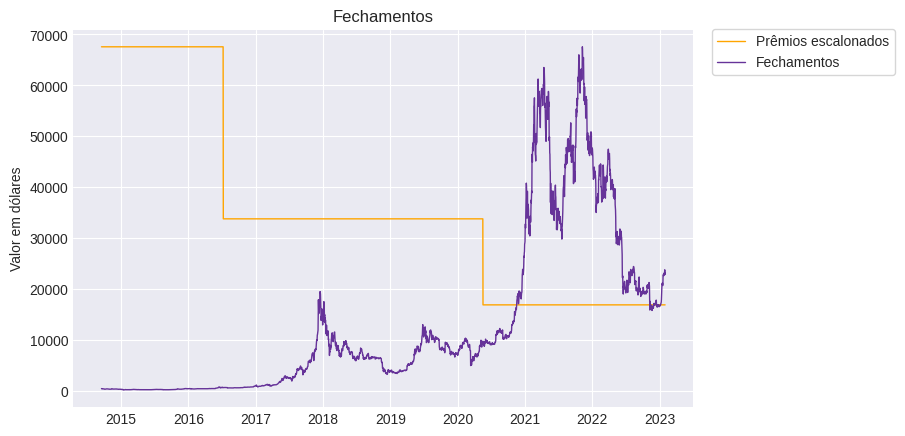

In [18]:
sns.lineplot(data=df_escala, x='Data', y='Premio', color='orange', linewidth=LINHA_ESPESSURA, label='Prêmios escalonados')
sns.lineplot(data=df_escala, x='Data', y='Fechamento', color=COR_TREINO, linewidth=LINHA_ESPESSURA, label='Fechamentos')

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares')

plt.legend(loc=(1.03, 0.88), frameon=True, facecolor='white');

# Modelos

0. Ingênuo
1. Denso (7 janelas, 1 horizonte.)
2. Denso (30 janelas, 1 horizonte.)
3. Denso (30 janelas, 7 horizontes.)
4. Conv1D
5. LSTM
6. Denso com dados multivariados
7. N-BEATS
8. Conjunto (Ensemble. Múltilplos modelos com funções de perda diferentes.)
9. Previsão futura
10. Denso com dados turcos (Turkey problem/data.)

---
Janelas: número de intervalos de tempo utilizados para fazer a previsão (passado).

Horizontes: número de intervalos de tempo da previsão (futuro).

In [19]:
metricas = [None] * 11

## Modelo 0: Ingênuo

Naïve method: https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method

Para previsões ingênuas, simplesmente definimos todas as previsões como o valor da observação anterior.

In [20]:
y_pred = y_test[:-1]

In [21]:
y_test[:10], y_test[-10:], y_pred[:10], y_pred[-10:]

(array([35678.128906, 37332.855469, 36684.925781, 37575.179688,
        39208.765625, 36894.40625 , 35551.957031, 35862.378906,
        33560.707031, 33472.632813]),
 array([22720.416016, 22934.431641, 22636.46875 , 23117.859375,
        23032.777344, 23078.728516, 23031.089844, 23774.566406,
        22840.138672, 23139.283203]),
 array([35678.128906, 37332.855469, 36684.925781, 37575.179688,
        39208.765625, 36894.40625 , 35551.957031, 35862.378906,
        33560.707031, 33472.632813]),
 array([22777.625   , 22720.416016, 22934.431641, 22636.46875 ,
        23117.859375, 23032.777344, 23078.728516, 23031.089844,
        23774.566406, 22840.138672]))

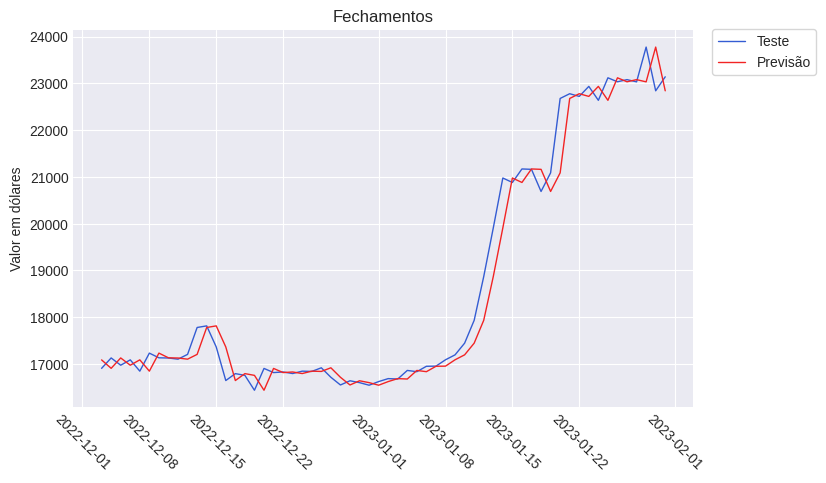

In [22]:
grafico_series(X_teste=X_test, y_teste=y_test,
               X_previsao=X_test[1:], y_previsao=y_pred,
               inicio=-60)

In [23]:
metricas[0] = metricas_modelo(y_test[1:], y_pred)

## Modelo 1: Denso (7 janelas, 1 horizonte.)

In [24]:
dados = df['Fechamento'].to_numpy().astype('float32')
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [25]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_1_denso_7j_1h'

modelo = Sequential(name=modelo_nome)

modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_relu'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 32.9 s, sys: 2.61 s, total: 35.5 s
Wall time: 46.2 s


In [26]:
modelo.summary()

Model: "modelo_1_denso_7j_1h"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_relu (Dense)         (None, 128)               1024      
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [27]:
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 3ms/step - loss: 901.7403 - mae: 901.7403 - mse: 1774061.7500


[901.7402954101562, 901.7402954101562, 1774061.75]

In [28]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 3ms/step - loss: 890.7335 - mae: 890.7335 - mse: 1745005.1250


[890.7335205078125, 890.7335205078125, 1745005.125]

In [29]:
previsoes = modelo.predict(janelas_teste)

20/20 [==============================] - 0s 2ms/step


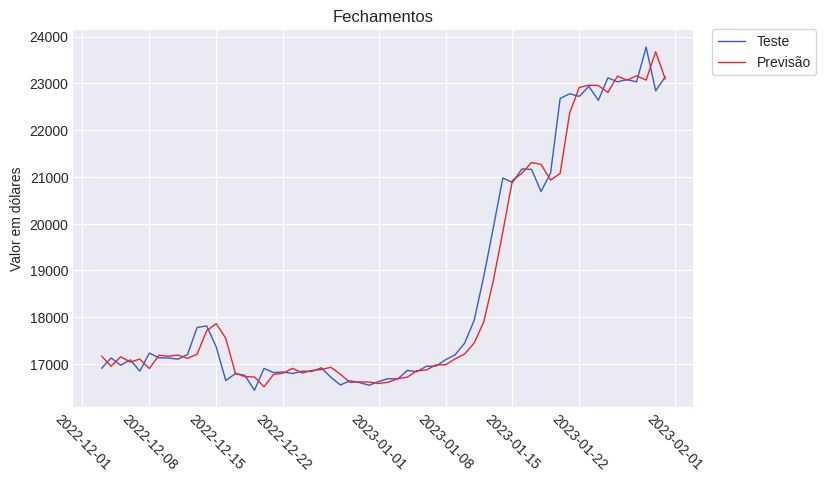

In [30]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [31]:
metricas[1] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 2: Denso (30 janelas, 1 horizonte.)

In [32]:
# dados = df['Fechamento'].to_numpy().astype('float32')
janela_tamanho = 30
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [33]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_2_denso_30j_1h'

modelo = Sequential(name=modelo_nome)

modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_relu'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 26.8 s, sys: 965 ms, total: 27.8 s
Wall time: 26 s


In [34]:
modelo.summary()

Model: "modelo_2_denso_30j_1h"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_relu (Dense)         (None, 128)               3968      
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [35]:
modelo.evaluate(janelas_teste, horizontes_teste)

19/19 [==============================] - 0s 3ms/step - loss: 1179.9772 - mae: 1179.9772 - mse: 2650640.7500


[1179.9771728515625, 1179.9771728515625, 2650640.75]

In [36]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

19/19 [==============================] - 0s 4ms/step - loss: 995.0159 - mae: 995.0159 - mse: 2068310.3750


[995.015869140625, 995.015869140625, 2068310.375]

In [37]:
previsoes = modelo.predict(janelas_teste)

19/19 [==============================] - 0s 2ms/step


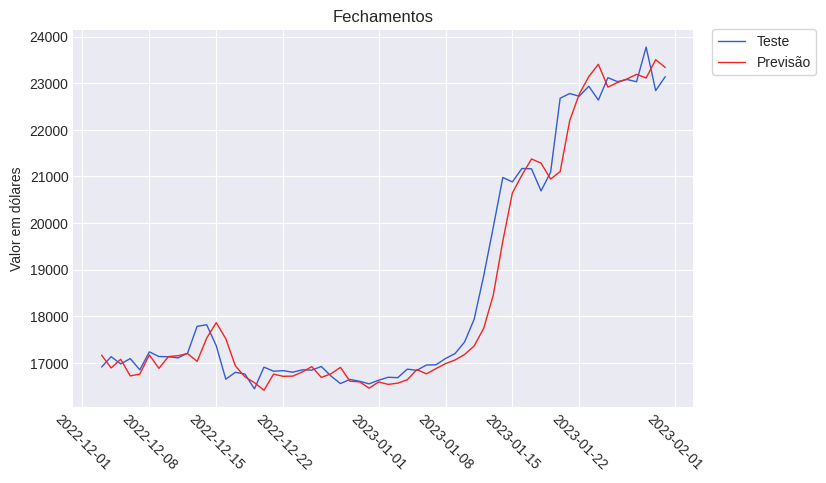

In [38]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [39]:
metricas[2] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 3: Denso (30 janelas, 7 horizontes.)

In [40]:
# dados = df['Fechamento'].to_numpy().astype('float32')
janela_tamanho = 30
horizonte_tamanho = 7

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [41]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_3_denso_30j_7h'

modelo = Sequential(name=modelo_nome)

modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_relu'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 28.4 s, sys: 967 ms, total: 29.3 s
Wall time: 30.2 s


In [42]:
modelo.summary()

Model: "modelo_3_denso_30j_7h"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_relu (Dense)         (None, 128)               3968      
                                                                 
 camada_saida (Dense)        (None, 7)                 903       
                                                                 
Total params: 4,871
Trainable params: 4,871
Non-trainable params: 0
_________________________________________________________________


In [43]:
modelo.evaluate(janelas_teste, horizontes_teste)

19/19 [==============================] - 0s 5ms/step - loss: 1842.2413 - mae: 1842.2413 - mse: 6937416.0000


[1842.2413330078125, 1842.2413330078125, 6937416.0]

In [44]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

19/19 [==============================] - 0s 3ms/step - loss: 1812.6919 - mae: 1812.6919 - mse: 6882409.0000


[1812.69189453125, 1812.69189453125, 6882409.0]

In [45]:
previsoes = modelo.predict(janelas_teste)

19/19 [==============================] - 0s 2ms/step


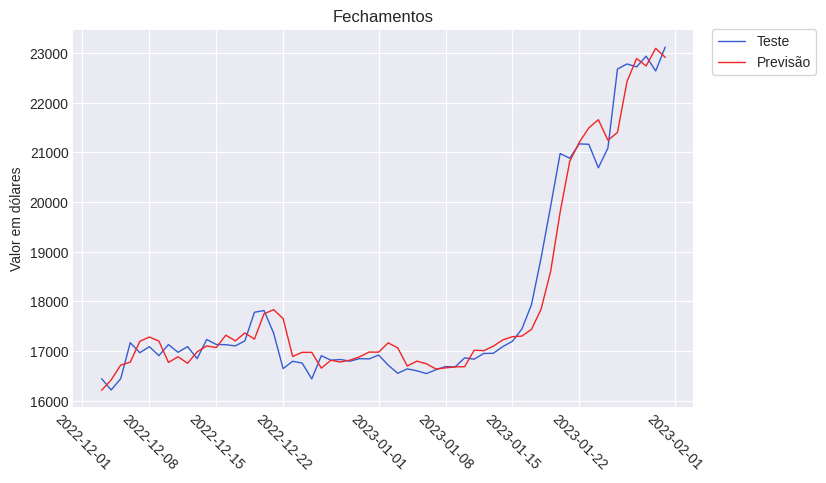

In [46]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, 0],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, 0],
               inicio=-60)

In [47]:
metricas[3] = metricas_modelo(horizontes_teste[:, 0], previsoes[:, 0])

## Modelo 4: Convulacional

In [48]:
# dados = df['Fechamento'].to_numpy().astype('float32')
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [49]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_4_convulacional'

modelo = Sequential(name=modelo_nome)

modelo.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))  # Adiciona uma dimensão aos dados.

modelo.add(Conv1D(filters=FILTROS,
                  kernel_size=janela_tamanho,
                  padding=PREENCHIMENTO,
                  activation=ATIVACAO_CNN,
                  name='camada_convulacional'))

modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 40 s, sys: 1.89 s, total: 41.9 s
Wall time: 42.7 s


In [50]:
modelo.summary()

Model: "modelo_4_convulacional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_lambda (Lambda)      (None, 1, 7)              0         
                                                                 
 camada_convulacional (Conv1  (None, 1, 128)           6400      
 D)                                                              
                                                                 
 camada_saida (Dense)        (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [51]:
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 5ms/step - loss: 966.4781 - mae: 966.4781 - mse: 1937287.7500


[966.4780883789062, 966.4780883789062, 1937287.75]

In [52]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 5ms/step - loss: 913.8862 - mae: 913.8862 - mse: 1794209.2500


[913.88623046875, 913.88623046875, 1794209.25]

In [53]:
previsoes = modelo.predict(janelas_teste)

20/20 [==============================] - 0s 3ms/step


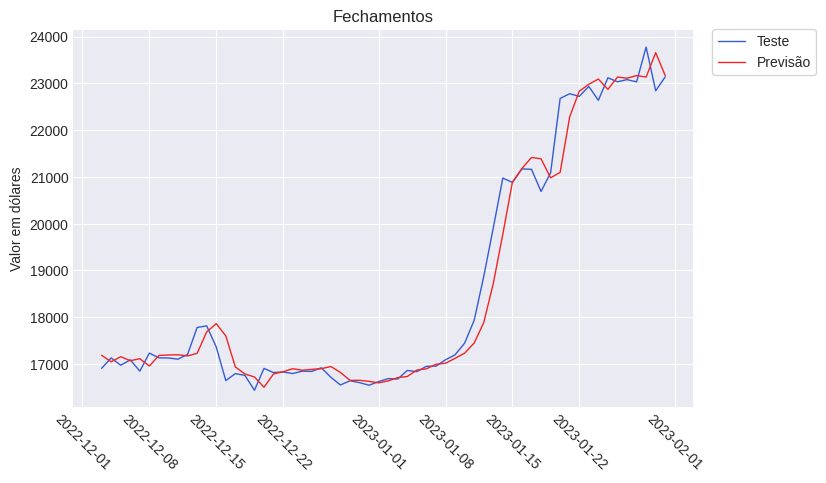

In [54]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [55]:
metricas[4] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 5: Memória de longa e curta durações (LSTM)

In [56]:
# dados = df['Fechamento'].to_numpy().astype('float32')
# janela_tamanho = 7
# horizonte_tamanho = 1

# janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

# janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [57]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_5_lstm'

modelo = Sequential(name=modelo_nome)

modelo.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))
modelo.add(LSTM(units=UNIDADES, activation=ATIVACAO_CNN, name='camada_lstm'))  # Ativação 'relu' no lugar de 'tanh' por motivo de performance.
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

# entradas = Input(shape=janela_tamanho, name='camada_entrada')

# camadas = Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda')(entradas)
# camadas = LSTM(units=UNIDADES, activation=ATIVACAO_CNN, name='camada_lstm')(camadas)

# saidas = Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida')(camadas)

# modelo = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 1min 52s, sys: 2.85 s, total: 1min 55s
Wall time: 2min 24s


In [58]:
modelo.summary()

Model: "modelo_5_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_lambda (Lambda)      (None, 1, 7)              0         
                                                                 
 camada_lstm (LSTM)          (None, 128)               69632     
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [59]:
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 4ms/step - loss: 969.3216 - mae: 969.3216 - mse: 1943505.1250


[969.3215942382812, 969.3215942382812, 1943505.125]

In [60]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 1s 4ms/step - loss: 954.8729 - mae: 954.8729 - mse: 1873558.2500


[954.8729248046875, 954.8729248046875, 1873558.25]

In [61]:
previsoes = modelo.predict(janelas_teste)

20/20 [==============================] - 0s 3ms/step


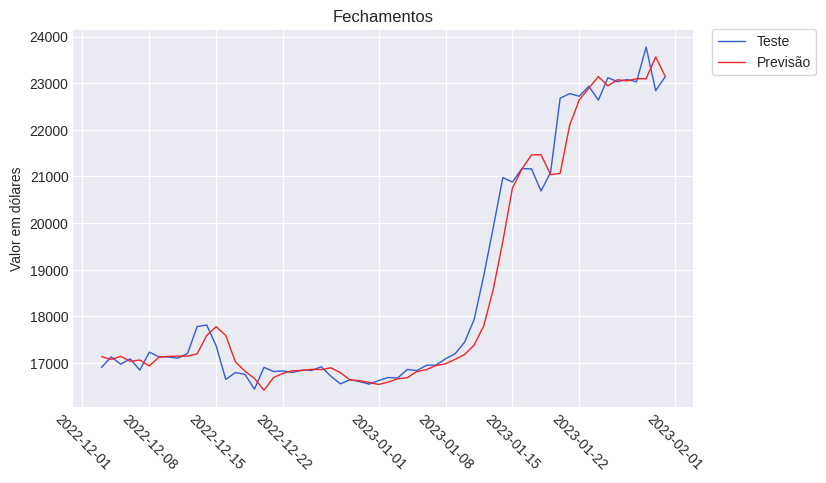

In [62]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [63]:
metricas[5] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 6: Denso (dados multivariados)

In [64]:
dados = df['Fechamento'].to_numpy().astype('float32')
premios = df['Premio'].to_numpy().astype('float32')
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho, premios)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [65]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_6_denso_multi'

modelo = Sequential(name=modelo_nome)

modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_relu'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 29.3 s, sys: 1.02 s, total: 30.3 s
Wall time: 41.7 s


In [66]:
modelo.summary()

Model: "modelo_6_denso_multi"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_relu (Dense)         (None, 128)               1152      
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [67]:
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 3ms/step - loss: 955.7690 - mae: 955.7690 - mse: 1888671.3750


[955.76904296875, 955.76904296875, 1888671.375]

In [68]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 4ms/step - loss: 884.1668 - mae: 884.1668 - mse: 1701979.0000


[884.1668090820312, 884.1668090820312, 1701979.0]

In [69]:
previsoes = modelo.predict(janelas_teste)

20/20 [==============================] - 0s 2ms/step


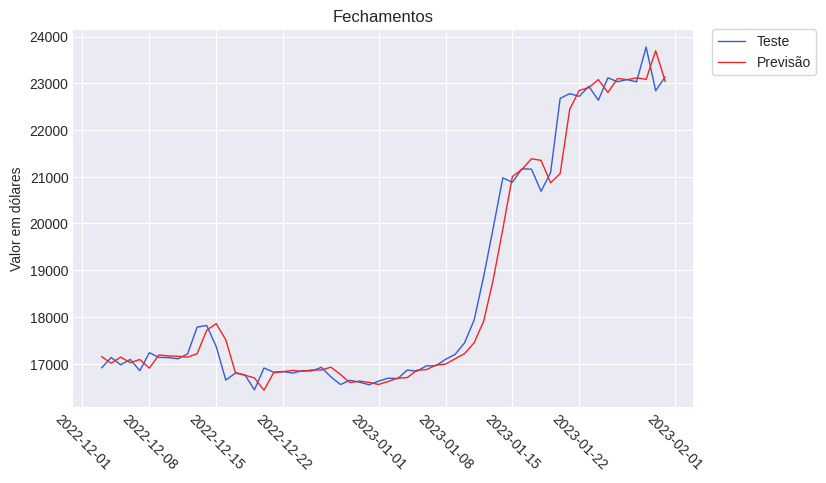

In [70]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [71]:
metricas[6] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 7: N-BEATS

N-BEATS: Neural basis expansion analysis for interpretable time series forecasting https://arxiv.org/abs/1905.10437

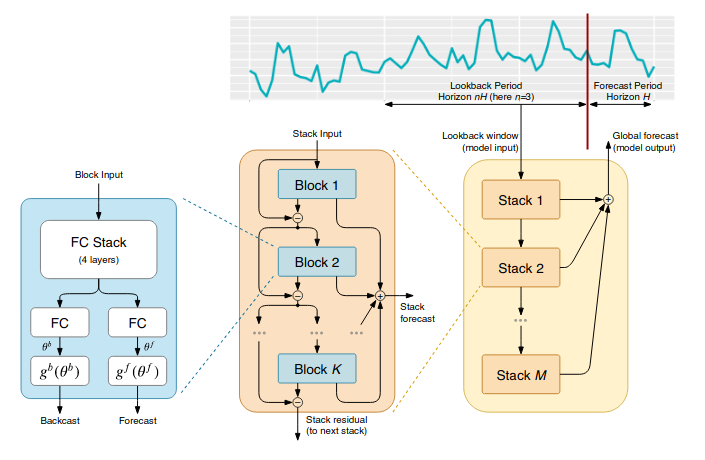

(Do artigo) **Figure 1: Proposed architecture**. The basic building block is a multi-layer Fully Connected (FC) network with ReLU nonlinearities. It predicts basis expansion coefficients both forward, $\theta^f$ (forecast), and backward, $\theta^b$ (backcast). Blocks are organized into stacks using doubly residual stacking principle. A stack may have layers with shared $g^b$ and $g^f$. Forecasts are aggregated in hierarchical fashion. This enables building a very deep neural network with interpretable outputs.


Making new Layers and Models via subclassing https://www.tensorflow.org/guide/keras/custom_layers_and_models

De acordo com o [código fonte](https://github.com/tensorflow/tensorflow/blob/fcc4b966f1265f466e82617020af93670141b009/tensorflow/python/keras/engine/base_layer.py#L308-L316) (em 09.02.2023), os kwargs permitidos pela classe `Layer` são: `input_dim`, `input_shape`, `batch_input_shape`, `batch_size`, `weights`, `activity_regularizer` e `autocast`. Além destes, `Layer` possui os argumentos `trainable`, `name`, `dtype` e `dynamic`.

### Camada de bloco. Classe NBeatsBlock.

A seção 3 do artigo descreve a arquitetura do modelo. Para este modelo foi utilizada a arquitetura genérica, descrita na seção 3.3, que não utiliza conhecimentos específicos de séries temporais.

In [72]:
class NBeatsBlock(Layer):
    def __init__(self,
                 input_size: int,
                 horizon: int,
                 n_neurons: int,
                 **kwargs):

        super().__init__(**kwargs)

        self.input_size = input_size  # Tamanho da entrada.
        self.horizon    = horizon     # Tamanho da saída.
        self.n_neurons  = n_neurons   # Quantidade de neurônios.

        self.theta_size = input_size + horizon  # Tamanho do coeficiente de expansão.

        self.hidden      = [Dense(units=n_neurons, activation='relu') for _ in range(4)]  # Camadas densas (FC) ReLU (x4).
        self.theta_layer = Dense(units=self.theta_size, activation='linear')              # Camada theta linear, para backcast e forecast.

    def call(self, inputs):

        x = inputs

        for layer in self.hidden:
            x = layer(x)

        theta = self.theta_layer(x)

        backcast = theta[:, :self.input_size]
        forecast = theta[:, -self.horizon:]

        return backcast, forecast

### Teste da classe NBeatsBlock

In [73]:
tf.random.set_seed(SEMENTE)

camada_teste = NBeatsBlock(input_size=7,
                           horizon=1,
                           n_neurons=128)

In [74]:
entradas_teste = tf.expand_dims(tf.range(janela_tamanho) + 1, axis=0)
entradas_teste

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [75]:
backcast, forecast = camada_teste(entradas_teste)

backcast.numpy(), forecast.numpy()

(array([[ 0.63903147,  0.45609343,  0.235834  ,  0.28175455,  0.23439437,
         -0.07022671, -0.9584254 ]], dtype=float32),
 array([[0.50416225]], dtype=float32))

### Fusão de janelas e horizontes em datasets para ganho de performance.

Better performance with the tf.data API: https://www.tensorflow.org/guide/data_performance

In [76]:
dados = df['Fechamento'].to_numpy().astype('float32')
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [77]:
# Datasets
dataset_janelas_treino    = Dataset.from_tensor_slices(janelas_treino)
dataset_janelas_teste     = Dataset.from_tensor_slices(janelas_teste)
dataset_horizontes_treino = Dataset.from_tensor_slices(horizontes_treino)
dataset_horizontes_teste  = Dataset.from_tensor_slices(horizontes_teste)

# Combinar janelas e horizontes
dataset_treino = Dataset.zip((dataset_janelas_treino, dataset_horizontes_treino))
dataset_teste  = Dataset.zip((dataset_janelas_teste, dataset_horizontes_teste))

# Pré-buscas
dataset_treino = dataset_treino.batch(TAMANHO_LOTE_DATASET).prefetch(AUTOTUNE)
dataset_teste  = dataset_teste.batch(TAMANHO_LOTE_DATASET).prefetch(AUTOTUNE)

dataset_treino, dataset_teste

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>)

### Hiperparâmetros (Tabela 18)

In [78]:
NBEATS_ITERACOES = 5000
NBEATS_NEURONIOS = 512
NBEATS_PILHAS    = 30
NBEATS_ENTRADA   = janela_tamanho * horizonte_tamanho
NBEATS_HORIZONTE = horizonte_tamanho

### Conexões residuais (Seção 3.2)

https://en.wikipedia.org/wiki/Residual_neural_network

https://paperswithcode.com/method/resnet

In [81]:
# Exemplo, com camadas TensorFlow.

tensor_teste_1 = tf.range(10) + 10
tensor_teste_2 = tf.range(10)

subtracao = Subtract()([tensor_teste_1, tensor_teste_2])
adicao    = Add()([tensor_teste_1, tensor_teste_2])

print(f"Tensor 1..: {tensor_teste_1.numpy()}")
print(f"Tensor 2..: {tensor_teste_2.numpy()}")
print(f"Subtração.: {subtracao.numpy()}")
print(f"Adição....: {adicao.numpy()}")

Tensor 1..: [10 11 12 13 14 15 16 17 18 19]
Tensor 2..: [0 1 2 3 4 5 6 7 8 9]
Subtração.: [10 10 10 10 10 10 10 10 10 10]
Adição....: [10 12 14 16 18 20 22 24 26 28]


### Modelo

In [94]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_7_n_beats'

entradas = Input(shape=(NBEATS_ENTRADA), name='camada_entrada')

residuo, previsao = NBeatsBlock(input_size=NBEATS_ENTRADA,
                                horizon=NBEATS_HORIZONTE,
                                n_neurons=NBEATS_NEURONIOS,
                                name='bloco_0')(entradas)

for p in range(1, NBEATS_PILHAS):

    residuo_pilha, previsao_pilha = NBeatsBlock(input_size=NBEATS_ENTRADA,
                                                horizon=NBEATS_HORIZONTE,
                                                n_neurons=NBEATS_NEURONIOS,
                                                name=f'bloco_{p}')(residuo)

    residuo  = Subtract(name=f"subtracao_{p}")([residuo, residuo_pilha])
    previsao = Add(name=f"adicao_{p}")([previsao, previsao_pilha])

modelo = Model(inputs=entradas, outputs=previsao, name=modelo_nome)

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(dataset_treino,
           epochs=NBEATS_ITERACOES,
           validation_data=dataset_teste,
           callbacks=[EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                      ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)],
           verbose=0)


Epoch 794: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1155: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1255: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 6min 38s, sys: 7.44 s, total: 6min 45s
Wall time: 7min 24s


In [95]:
modelo.summary()

Model: "modelo_7_n_beats"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 camada_entrada (InputLayer)    [(None, 7)]          0           []                               
                                                                                                  
 bloco_0 (NBeatsBlock)          ((None, 7),          796168      ['camada_entrada[0][0]']         
                                 (None, 1))                                                       
                                                                                                  
 bloco_1 (NBeatsBlock)          ((None, 7),          796168      ['bloco_0[0][0]']                
                                 (None, 1))                                                       
                                                                                   

In [96]:
modelo.evaluate(dataset_teste)

1/1 [==============================] - 0s 84ms/step - loss: 891.4479 - mae: 891.4479 - mse: 1727761.7500


[891.4479370117188, 891.4479370117188, 1727761.75]

In [97]:
previsoes = modelo.predict(dataset_teste)

1/1 [==============================] - 2s 2s/step


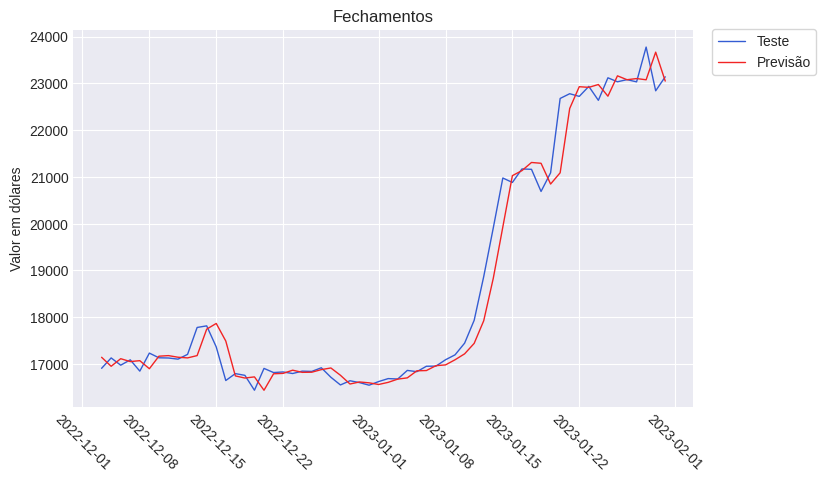

In [98]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [99]:
metricas[7] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

# Outros modelos

Other kinds of time series forecasting models which can be used for baselines and actual forecasts: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

# Comparação dos modelos

In [117]:
df_metricas = pd.DataFrame([m for m in metricas if m is not None])
df_metricas.T

,0,1,2,3,4,5,6,7
Mean Absolute Error,860.374223,890.733398,995.015869,1011.628906,913.886047,954.873047,884.166809,891.448059
Root Mean Squared Error,1274.550527,1320.986450,1438.162109,1453.849243,1339.480957,1368.779907,1304.599243,1314.443481
Mean Absolute Percentage Error,0.024247,0.025219,0.028144,0.028723,0.025887,0.027023,0.024991,0.025159
Mean Absolute Scaled Error,1.001516,1.036855,1.163918,1.170817,1.063806,1.111517,1.029212,1.037687


In [118]:
df_metricas['Mean Absolute Error'].sort_values()

0     860.374223
6     884.166809
1     890.733398
7     891.448059
4     913.886047
5     954.873047
2     995.015869
3    1011.628906
Name: Mean Absolute Error, dtype: float64

In [119]:
# for titulo in metricas[0].keys():
#     grafico_metrica([m[titulo] for m in metricas if m is not None], titulo)